<font size="5">
 <div class="alert alert-block alert-info"> <b>Week 7: Deep Neural Networks (DNNs)<b>
     </div>
</font>

      
    
  <font size="4"> MCD - Análise de Séries Temporais e Previsão </font>
  
  
  <font size="3"> **Filipe R. Ramos** </font>
      
   
  <font size="3"> *frjrs@iscte-iul.pt* </font>  
   
    
  <font size="3">ISCTE-IUL </font>

<font size="5">
    <div class="alert alert-warning" role="alert"> -- Deep Neural Networks -- </div> </font>

## **Agenda**

1. **Deep Neural Networks (DNNs): Introduction**

2. **Recurrent Neural Networks (RNNs)**

3. **Gated recurrent units (GRUs)**

4. **Long Short-Term Memory (LSTM)**
---------------------


## **References**
- [Chollet, F. (2017)](https://sourestdeeds.github.io/pdf/Deep%20Learning%20with%20Python.pdf)

- [Haykin, S. (2009)](https://lps.ufrj.br/~caloba/Livros/Haykin2009.pdf)


- [Introduction to Machine Learning with Python  book](https://learning.oreilly.com/library/view/introduction-to-machine/9781449369880/)

---------------------


<font size="5"> <div class="alert alert-success" role="alert"> **Objetivos** </div></font>

- Entender o funcionamento básico de diferentes RNNs (SimpleRNN, LSTM, GRU).
- Observar sinais de overfitting durante o treino.
- Interpretar as curvas de perda (loss curves) de treino e validação.

# **Import libraries**

In [4]:
### bibliotecas


# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, GRU
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import MinMaxScaler

# **Define Functions**

In [5]:
# Define ts_train_test_normalize function
def ts_train_test_normalize(data, seq_length, test_size):
    """
    Prepares the time series data for training and testing.

    Args:
        data (np.ndarray): The time series data.
        seq_length (int): The length of the input sequence for the RNN.
        test_size (int): The number of data points to use for testing.

    Returns:
        tuple: X_train, y_train, X_test, scaler
    """
    scaler = MinMaxScaler(feature_range=(0, 1))
    data = scaler.fit_transform(data.reshape(-1, 1))

    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i, 0])
        y.append(data[i, 0])

    X = np.array(X)
    y = np.array(y)

    X_train = X[:-test_size]
    y_train = y[:-test_size]
    X_test = X[-test_size:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, scaler

# **Generate Data**

Vamos criar uma série temporal simples para treino.

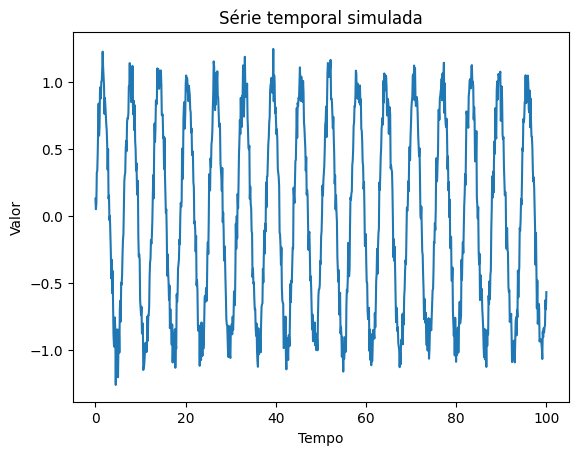

In [6]:
# Vamos criar uma série temporal simples para treino
def generate_data(n_samples=1000, noise=0.1):
    X = np.linspace(0, 100, n_samples)
    y = np.sin(X) + noise * np.random.randn(n_samples)
    return X, y

X, y = generate_data()

# Visualizar os primeiros dados
plt.plot(X, y)
plt.title("Série temporal simulada")
plt.xlabel("Tempo")
plt.ylabel("Valor")
plt.show()




# **Data Preparation**
Modelo sequencial com uma camada RNN simples

In [7]:
def create_sequences(X, y, seq_length=10):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(y[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

seq_length = 10
X_seq, y_seq = create_sequences(X, y, seq_length)

# Ajustar formato para (amostras, timesteps, features)
X_seq = X_seq[..., np.newaxis]

# Dividir em treino e teste
split = int(0.8 * len(X_seq))
X_train, X_test = X_seq[:split], X_seq[split:]
y_train, y_test = y_seq[:split], y_seq[split:]


# **Define the RNN Model**

In [11]:
# Função genérica para criar modelos RNN, LSTM ou GRU
def build_model(model_type='SimpleRNN', seq_length=10, units=20):
    model = Sequential()
    if model_type == 'SimpleRNN':
        model.add(SimpleRNN(units, activation='tanh', input_shape=(seq_length, 1)))
    elif model_type == 'LSTM':
        model.add(LSTM(units, activation='tanh', input_shape=(seq_length, 1)))
    elif model_type == 'GRU':
        model.add(GRU(units, activation='tanh', input_shape=(seq_length, 1)))
    else:
        raise ValueError("model_type deve ser 'SimpleRNN', 'LSTM' ou 'GRU'")

    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


# Escolher modelo
# Definir o tipo de RNN a utilizar
model_type = 'GRU'  # <- Pode mudar para 'LSTM' ou 'GRU'
model = build_model(model_type=model_type, seq_length=seq_length)


# Mostrar resumo do modelo
model.summary()



c:\Users\jfbot\Desktop\Mestrado\Análise de Séries Temporais e Previsão\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 20)             │         1,380 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,401 (5.47 KB)

 Trainable params: 1,401 (5.47 KB)

 Non-trainable params: 0 (0.00 B)

#**Train and Evaluate the Model**

In [12]:
# TREINAR MODELO
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Assuming 'y' from generate_data function is your time series data and you want to use the same test set size as in LSTM_model
_, _, X_test, sc = ts_train_test_normalize(y, 5, 2)
# Get y_test from the original 'y' data
y_test = y[-len(X_test):]

# Now scale y_test using the same scaler used for training
y_test = sc.transform(y_test.reshape(-1, 1)).ravel() # Scale y_test and flatten it


# AVALIAR MODELO
loss = model.evaluate(X_test, y_test)
print(f"Loss no conjunto de teste: {loss:.4f}")


Epoch 1/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - loss: 0.4334 - val_loss: 0.2212
Epoch 2/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1787 - val_loss: 0.0761
Epoch 3/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0734 - val_loss: 0.0569
Epoch 4/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0609 - val_loss: 0.0511
Epoch 5/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0504 - val_loss: 0.0451
Epoch 6/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0485 - val_loss: 0.0411
Epoch 7/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0438 - val_loss: 0.0375
Epoch 8/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0392 - val_loss: 0.0335
Epoch 9/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0357 - val_loss: 0.0315
Epoch 10/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0316 - val_loss: 0.0279
Epoch 11/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0308 - val_loss: 0.0256
Epoch 12/100
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

#**Visualise Loss Curves**

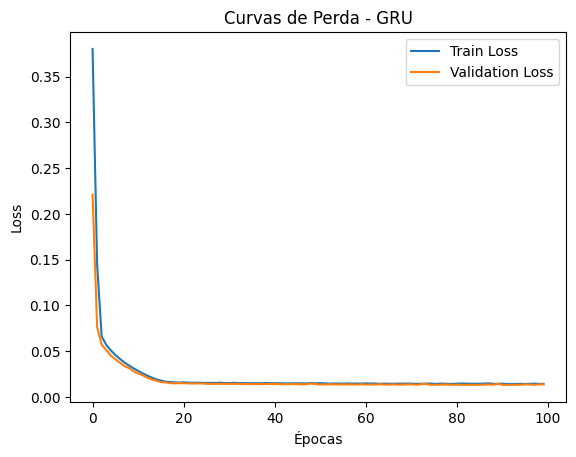

In [13]:
# VISUALIZAR CURVAS DE PERDA
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'Curvas de Perda - {model_type}')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.show()

# Nota Informativa - Interpretação das Curvas de Perda (Train e Validation)

A imagem mostra as curvas de **Train Loss** (Perda no Treino) e **Validation Loss** (Perda na Validação) ao longo das épocas de um modelo **SimpleRNN** para previsão de séries temporais.


🔵 Train Loss (Linha azul):
- Representa o erro do modelo nos dados de treino.

🟠 Validation Loss (Linha laranja):
- Representa o erro nos dados de validação, que não foram utilizados no treino.


---

## **1. Comportamento Ideal**
- ✅ Ambas as curvas (treino e validação) decrescem e estabilizam em um valor **baixo e similar**.  
- **Exemplo**: Se a perda final for ~0.1 para ambas, o modelo generaliza bem.

---

## **2. Problemas Comuns e Soluções**

### **📉 Overfitting (Sobreajuste)**
- **Sinal**:  
  - *Train Loss* ↘️ continua a diminuir.  
  - *Validation Loss* ↗️ aumenta após certa época.  
- **Causa**: Modelo memoriza os dados de treino.  
- **Solução**:  
  - Regularização (Dropout, L2).  
  - *Early stopping* (parada antecipada).  

### **📈 Underfitting (Subajuste)**
- **Sinal**:  
  - Ambas as curvas altas (ex.: >0.5) e não convergem.  
- **Causa**: Modelo muito simples ou treino insuficiente.  
- **Solução**:  
  - Aumentar unidades/camadas RNN.  
  - Treinar por mais épocas.  

### **🌀 Instabilidade**
- **Sinal**: Oscilações bruscas nas curvas.  
- **Causa**: *Learning rate* alto ou *batch size* pequeno.  
- **Solução**:  
  - Reduzir taxa de aprendizagem.  
  - Aumentar *batch size*.  

---

## **3. Observações para Séries Temporais**
- **Validação**: Usar divisão temporal (ex.: dados recentes para validação).  
- **Early Stopping**: Ativar se a *Validation Loss* não melhora em N épocas.  

---

## **4. Exemplo Prático (Imagem)**
- Se *Validation Loss* ↗️ após certa época → **Overfitting**.  
- Se ambas ↘️ lentamente → Pode precisar de mais épocas.  

**Ação Recomendada**:  
```python
# Código para early stopping (exemplo no Keras)
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(..., callbacks=[early_stop])
```
---

✅ Em geral:

- Queremos perdas baixas e curvas relativamente estáveis.
- A distância entre a perda de treino e a perda de validação deve ser pequena.
- O comportamento das curvas ajuda a decidir se é necessário alterar o modelo, os hiperparâmetros ou os dados.



---------------------------------

-----------------------------

## **Exercício:**

----------------------


**1. Modificar o tipo de modelo**
  
  - Experimente usar 'LSTM' ou 'GRU' em vez de 'SimpleRNN'.
  - Compare as curvas de perda e o valor final da loss.


- **Questão:** Qual das arquiteturas teve melhor capacidade de generalização?

----------------------

**2. Alterar o número de unidades**

 - Aumente `units` de 20 para 50.

 - Observe o impacto nas curvas de treino e validação.



- **Questão:** O modelo ficou mais sujeito a overfitting?

----------------------

**3. Alterar o tamanho do `batch`**

 - Experimente `batch_size` de 64 ou 128.
 - Observe o impacto na estabilidade e velocidade do treino.


- **Questão:** O treino ficou mais rápido? Mais estável?

----------------------

**4. Aumentar o ruído nos dados**

 - Aumente o parâmetro noise da função `generate_data`..
 - Observe como é que o modelo lida com dados mais "ruído".


- **Questão:** Alguma arquitetura (SimpleRNN, LSTM ou GRU) lida melhor com mais ruído?


----------------------


# **Notas Finais**
- Sinais de overfitting: perda de validação começa a aumentar enquanto a perda de treino continua a diminuir.

- EarlyStopping é uma técnica para mitigar overfitting automaticamente.



----------------------


# **Desafio**
- Como aumentar o número de camadas na rede neuronal?


## **Resolução dos exercícios:**

----------------------


**1. Modificar o tipo de modelo**
  
  - Experimente usar 'LSTM' ou 'GRU' em vez de 'SimpleRNN'.
  - Compare as curvas de perda e o valor final da loss.


- **Questão:** Qual das arquiteturas teve melhor capacidade de generalização?

    + SimpleRNN:

    | Layer (type)           | Output Shape   | Param #  |
    |------------------------|----------------|----------|
    | simple_rnn (SimpleRNN) | (None, 20)     | 440      |
    | dense (Dense)          | (None, 1)      | 21       |

    Total params: 461 (1.80 KB)  
    Trainable params: 461 (1.80 KB)  
    Non-trainable params: 0 (0.00 B)

    Loss no conjunto de teste: 0.0058

    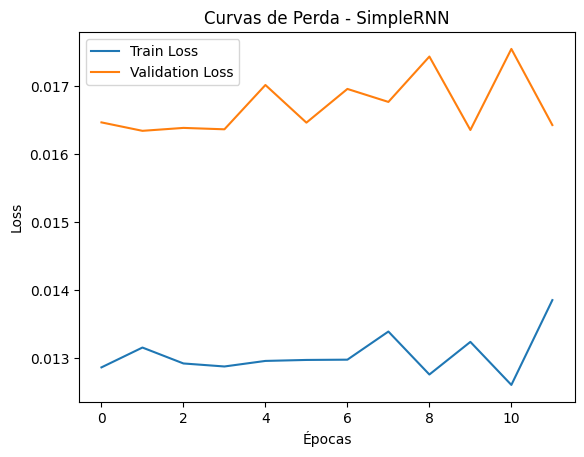

    + LSTM:

    Model: "sequential"
    | Layer (type)           | Output Shape   | Param #  |
    |------------------------|----------------|----------|
    | lstm (LSTM)            | (None, 20)     | 1,760    |
    | dense (Dense)          | (None, 1)      | 21       |

    Total params: 1,781 (6.96 KB)  
    Trainable params: 1,781 (6.96 KB)  
    Non-trainable params: 0 (0.00 B)

    Loss no conjunto de teste: 0.0032

    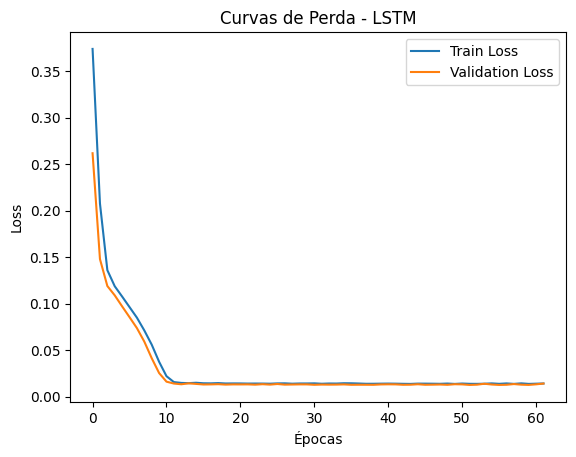

    + GRU:

    Model: "sequential_1"
    | Layer (type)           | Output Shape   | Param #  |
    |------------------------|----------------|----------|
    | gru (GRU)              | (None, 20)     | 1,380    |
    | dense_1 (Dense)        | (None, 1)      | 21       |

    Total params: 1,401 (5.47 KB)  
    Trainable params: 1,401 (5.47 KB)  
    Non-trainable params: 0 (0.00 B)

    Loss no conjunto de teste: 0.0084

    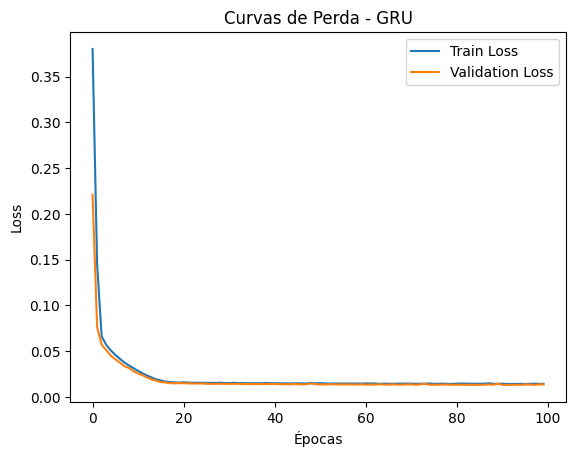

----------------------